# Offline fields consistency check
This notebook checks to make sure that the accumulated mass transports, freshwater fluxes, and layer thicknesses stored from an online run are consistent. The change in the total thickness of the column equals the column integral of the convergence of the horizontal mass transports and the freshwater fluxes.

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
%matplotlib notebook
from IPython.core.display import display, HTML

In [5]:
# Set paths to read from
inpath = '/home/aes/git/ashao_forks/MOM6-examples/ice_ocean_SIS2/Mediterranean_z_05/ONLINE/gaea/'
sum_file = inpath + '00030101.off_sum_1day_woa.nc'
snap_file = inpath + '00030101.off_snap_1day_woa.nc'
grid_file = inpath + 'Med_05.grid.nc'

In [8]:
def reconstruct_h(tidx):
    # Layer thickness at the beginning of the timestep
    hstart = nc.Dataset(snap_file).variables['h_end'][tidx-1,:,:,:].data
    # The end of timestep thicknesses from the prognostic model
    h_end = nc.Dataset(snap_file).variables['h_end'][tidx,:,:,:].data
    # U-Direction mass transport
    uhtr = nc.Dataset(sum_file).variables['uhtr_sum'][tidx,:,:,:].data
    # V-Direction mass transport
    vhtr = nc.Dataset(sum_file).variables['vhtr_sum'][tidx,:,:,:].data
    # Freshwater fluxes
    massout_flux = nc.Dataset(sum_file).variables['massout_flux_sum'][tidx,:,:].data
    # Area of the T-cell
    area = nc.Dataset(grid_file).variables['area_t'][:,:]
    
    # Initialize convergence arrays
    uh_conv = np.zeros_like(hstart)
    vh_conv = np.zeros_like(hstart)
    
    # Calculate convergence at edge of the domain (this assumes no reentrance), alternate code for reentrance is commented out
    uh_conv[:,:,0] = -uhtr[:,:,0]
    vh_conv[:,0,:] = -vhtr[:,0,:]
    # If reentrant in U-direction
    # uh_conv[:,:,0] = uhtr[:,:-1]-uhtr[:,:,0]
    # If reentran in V-Direction
    # vh_conv[:,0,:] = vhtr[:,-1,:]-uhtr[:,0,:]

    # Convergence everywhere else in the domain
    uh_conv[:,:,1:] = uhtr[:,:,0:-1] - uhtr[:,:,1:]
    vh_conv[:,1:,:] = vhtr[:,0:-1,:] - vhtr[:,1:,:]
    
    # Reconstruct the layer thicknesses
    h_reconstruct = hstart + (uh_conv + vh_conv)/area + massout_flux
        
    # Plot column integrals of convergence and thicknesses
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1)
    plt.pcolormesh(uh_conv.sum(axis=0)) ; plt.colorbar() ; plt.title('UH Convergence')
    plt.subplot(2,2,2)
    plt.pcolormesh(vh_conv.sum(axis=0)) ; plt.colorbar() ; plt.title('VH Convergence')
    plt.subplot(2,2,3)
    plt.pcolormesh(h_end.sum(axis=0)) ; plt.colorbar() ; plt.title('Total H Prognostic')
    plt.subplot(2,2,4)
    plt.pcolormesh(h_reconstruct.sum(axis=0)) ; plt.colorbar() ; plt.title('Total H Diagnostic')
    
    plt.figure()
    plt.pcolormesh(h_reconstruct.sum(axis=0)-h_end.sum(axis=0)); plt.colorbar()

    # Print the total errors between reconstructed and prognosed thicknesses
    diff_h=(h_reconstruct-h_end)
    print('Domain RMS difference: %e' % np.mean(np.square(diff_h)))

<IPython.core.display.Javascript object>


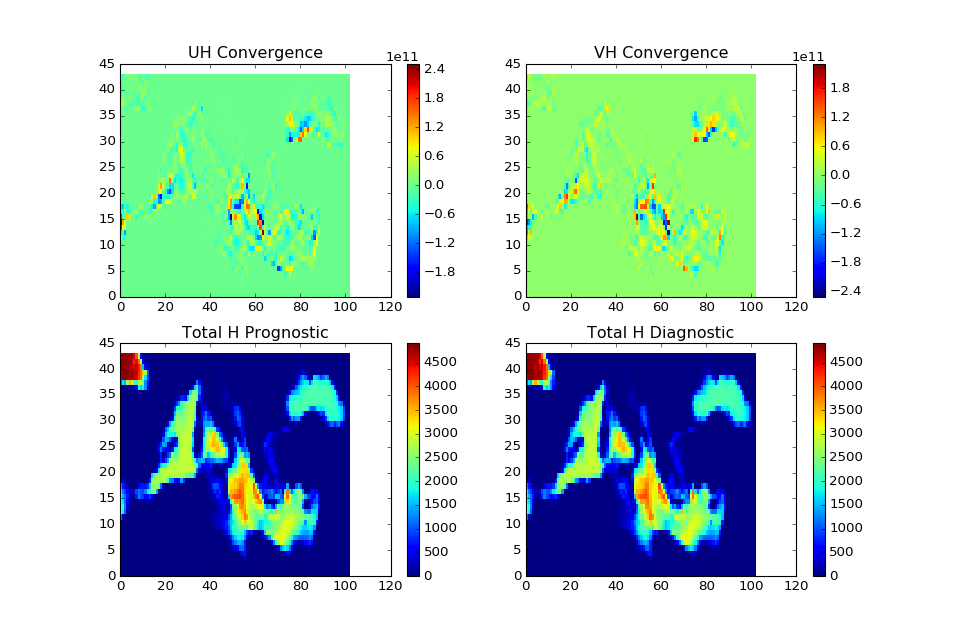

<IPython.core.display.Javascript object>


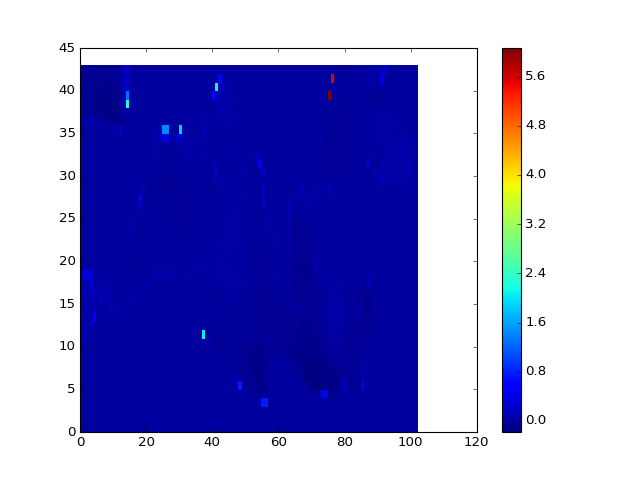

Domain RMS difference: 9.022791e-01


In [10]:
reconstruct_h(20)